# Imports

In [2]:
from pathlib import Path
import os
import pandas as pd
import torch as tc
import torchvision as tv
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from torchsummary import summary as ts
import numpy as np

# Dataset and Dataloader

In [19]:
input_file = Path(r"C:/Users/Michał/Documents/SI/resources/beer_labels.zip") # Path to the "beer_labels.zip"
output_folder = Path(r"C:/Users/Michał/Documents/SI/workdir/beer_labels") # Path to the folder where to unzip the input ".zip" file

os.chdir(output_folder)

dirs = [d for d in os.listdir() if os.path.isdir(d)]

# for i, dir_name in enumerate(dirs):
#     os.rename(dir_name, str(i))

print(f"Input file path: {input_file}")
print(f"Output folder path: {output_folder}")

dataset_path = Path("C:/Users/Michał/Documents/SI/workdir/")
training_csv_path = os.path.join(dataset_path, "training.csv")
validation_csv_path = os.path.join(dataset_path, "validation.csv")
testing_csv_path = os.path.join(dataset_path, "testing.csv")

classes = []
for name in os.listdir(output_folder):
    if os.path.isdir(os.path.join(output_folder, name)):
        classes.append(name)

print(classes)

Input file path: C:\Users\Michał\Documents\SI\resources\beer_labels.zip
Output folder path: C:\Users\Michał\Documents\SI\workdir\beer_labels
['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '5', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '6', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '7', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '8', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '9', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99']


In [4]:
all_cases = []

for current_class in classes:
    class_path = os.path.join(output_folder, current_class)
    image_files = os.listdir(class_path)

    for i in range(len(image_files)):
        image_path = os.path.join(class_path, image_files[i])
        all_cases.append((image_path,  current_class))
      
train_cases, test_cases = train_test_split(all_cases, test_size=0.2, random_state=42)
train_cases, val_cases = train_test_split(train_cases, test_size=0.125, random_state=42)

train_df = pd.DataFrame(train_cases, columns=["image_path", "image_class_name"])
train_df.to_csv(training_csv_path)

val_df = pd.DataFrame(val_cases, columns=["image_path", "image_class_name"])
val_df.to_csv(validation_csv_path)

test_df = pd.DataFrame(test_cases, columns=["image_path", "image_class_name"])
test_df.to_csv(testing_csv_path)


In [5]:
class BeerDataset(tc.utils.data.Dataset):
    def __init__(self, dataset_path, csv_path, transforms=None, z_norm=False):
        self.dataset_path = dataset_path
        self.csv_path = csv_path
        self.dataframe = pd.read_csv(csv_path)
        self.transforms = transforms
        self.z_norm = z_norm

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        image_path = self.dataframe.at[idx, 'image_path']
        current_image = tv.io.read_image(image_path)
        current_class = self.dataframe.at[idx, 'image_class_name']

        current_image = tv.transforms.functional.resize(current_image, (224,224), antialias=True)
        
        if self.z_norm:
          current_image = tv.transforms.functional.normalize(current_image, (0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
          current_image = current_image.astype(tc.float32)
        else:
            current_image = current_image / 255.0
            current_image = (current_image - 0.5) / 0.5
        
        return current_image, current_class

In [5]:
batch_size = 16
shuffle = True
training_dataset = BeerDataset(os.path.join(dataset_path, "Training"), training_csv_path)
training_dataloader = tc.utils.data.DataLoader(training_dataset, batch_size=batch_size, shuffle=shuffle)

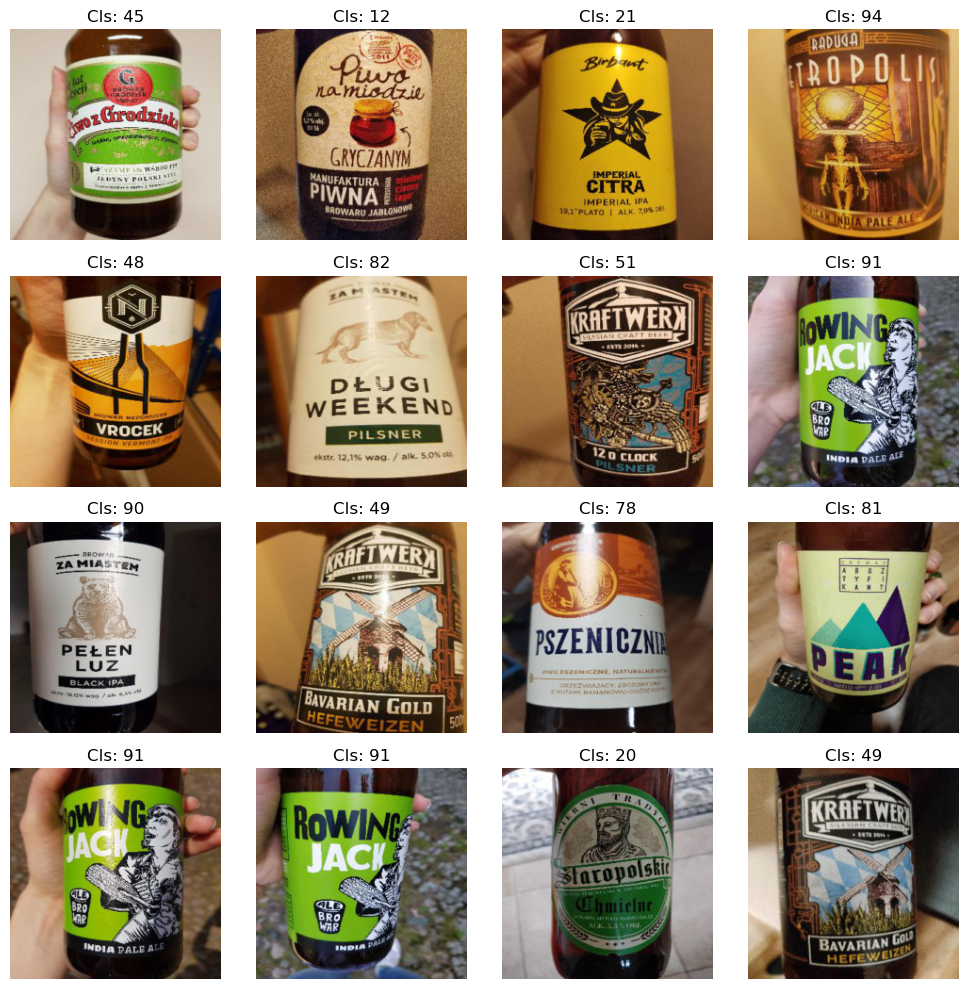

In [6]:
for images, classes in training_dataloader:
    fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10))

    for i, ax in enumerate(axes.flat):
        image = np.transpose(images[i].numpy(), (1, 2, 0))
        image = (image + 1) / 2
        ax.set_title("Cls: " + str(classes[i].item()))
        ax.imshow(image)
        ax.axis("off")

    plt.tight_layout()
    plt.show()
    break

# Neural Networks' Architectures

In [6]:
class SimpleClassificationNetwork(tc.nn.Module):
    def __init__(self):
        super(SimpleClassificationNetwork, self).__init__()
        self.cnn = tc.nn.Sequential(
            tc.nn.Conv2d(3, 32, 3, 1, 1),
            tc.nn.BatchNorm2d(32),
            tc.nn.ReLU(),
            tc.nn.AdaptiveAvgPool2d((1,1))
        )
        self.nn = tc.nn.Sequential(
            tc.nn.Linear(32, 64),
            tc.nn.ReLU(),
            tc.nn.Linear(64, 64),
            tc.nn.ReLU(),
            tc.nn.Linear(64, 100)  # change output classes = 100
        )

    def forward(self, x):
        x = self.cnn(x)
        x = x.view(x.size(0), -1)
        x = self.nn(x)
        return x

In [17]:
device = "cuda:0" if tc.cuda.is_available() else "cpu"
#device = "cpu"

print("Device: " + device)

simple_classification_network = SimpleClassificationNetwork()

batch_size = 4
random_input = tc.randn((batch_size, 3, 224, 224))
random_output = simple_classification_network(random_input)

print(f"Size of the random input: {random_input.size()}")
print(f"Size of the random output: {random_output.size()}")
print("Random output: ")
print(random_output)

print("Network summary: ")
ts(simple_classification_network.to(device), (3, 224, 224))

Device: cuda:0
Size of the random input: torch.Size([4, 3, 224, 224])
Size of the random output: torch.Size([4, 100])
Random output: 
tensor([[ 0.0284,  0.0928,  0.0638,  0.0657,  0.0251,  0.0173,  0.0297, -0.1860,
         -0.1392, -0.1330,  0.0857, -0.0070, -0.1477, -0.1133, -0.0838,  0.0931,
         -0.1062, -0.0036,  0.0842, -0.0891,  0.1037, -0.0161, -0.0864,  0.1743,
          0.1548,  0.0502,  0.0368, -0.0523, -0.1406,  0.0435,  0.0301,  0.1620,
          0.0932, -0.0056,  0.0010,  0.1544, -0.1289, -0.1075, -0.0750,  0.0784,
          0.0522,  0.0629, -0.0978,  0.1480,  0.1061,  0.1165, -0.0275,  0.0245,
          0.1258, -0.0137, -0.0913, -0.0422,  0.0496,  0.0947,  0.0586,  0.0825,
         -0.0695,  0.0478, -0.0483, -0.0927, -0.0100, -0.0523,  0.0523,  0.1087,
          0.0451, -0.0904,  0.0076, -0.0197, -0.0675, -0.0180, -0.0865,  0.0235,
          0.0046,  0.0018, -0.0629,  0.1422, -0.0346,  0.1093, -0.1344,  0.0310,
         -0.0060,  0.1135,  0.0339, -0.1081, -0.0571, -0

In [7]:
class ClassificationNetwork(tc.nn.Module):
    #TODO - implement the neural network architecture
    def __init__(self):
        super(ClassificationNetwork, self).__init__()
        self.cnn = tc.nn.Sequential(
            tc.nn.Conv2d(3, 32, 3, 1, 1),
            tc.nn.BatchNorm2d(32),
            tc.nn.ReLU(),
            tc.nn.Conv2d(32, 64, 3, 2, 2),
            tc.nn.BatchNorm2d(64),
            tc.nn.ReLU(),
            tc.nn.Conv2d(64, 64, 3, 1, 1),
            tc.nn.BatchNorm2d(64),
            tc.nn.ReLU(),
            tc.nn.Conv2d(64, 64, 3, 2, 2),
            tc.nn.BatchNorm2d(64),
            tc.nn.ReLU(),
            tc.nn.Conv2d(64, 64, 3, 2, 2),
            tc.nn.BatchNorm2d(64),
            tc.nn.ReLU(),
            tc.nn.Conv2d(64, 64, 3, 2, 1),
            tc.nn.BatchNorm2d(64),
            tc.nn.ReLU(),
            tc.nn.AdaptiveAvgPool2d((1,1))
        )
        self.nn = tc.nn.Sequential(
            tc.nn.Linear(64, 64),
            tc.nn.ReLU(),
            tc.nn.Linear(64, 64),
            tc.nn.ReLU(),
            tc.nn.Linear(64, 100)
        )

    def forward(self, x):
        # TODO - implement the forward pass
        x = self.cnn(x)
        x = x.view(x.size(0), -1)
        x = self.nn(x)
        return x

In [34]:
device = "cuda:0" if tc.cuda.is_available() else "cpu"

classification_network = ClassificationNetwork()

batch_size = 4
random_input = tc.randn((batch_size, 3, 224, 224))
random_output = classification_network(random_input)

print(f"Size of the random input: {random_input.size()}")
print(f"Size of the random output: {random_output.size()}")
print("Random output: ")
print(random_output)

print("Network summary: ")
ts(classification_network.to(device), (3, 224, 224))

Size of the random input: torch.Size([4, 3, 224, 224])
Size of the random output: torch.Size([4, 100])
Random output: 
tensor([[-0.0358,  0.0776,  0.0107,  0.0208,  0.0837,  0.0115, -0.0253, -0.1134,
         -0.0042,  0.1275,  0.0893,  0.0017, -0.1082,  0.0273, -0.1114,  0.0958,
         -0.0319,  0.0925,  0.0645,  0.0143, -0.0347,  0.0683, -0.0312, -0.0166,
         -0.1362, -0.1192,  0.0820, -0.1304, -0.0745, -0.0506, -0.0485,  0.0544,
         -0.0831, -0.1284,  0.0387, -0.0108, -0.0694,  0.0731, -0.1126,  0.0304,
         -0.0347, -0.0781, -0.0032,  0.0978, -0.1097,  0.0772,  0.1155,  0.0708,
          0.1525,  0.0284,  0.0755,  0.0545, -0.0609,  0.0592,  0.0260, -0.1720,
         -0.0792, -0.1268,  0.0364,  0.0326,  0.0429,  0.0217,  0.0363,  0.0596,
         -0.0575, -0.0313, -0.0184,  0.0073,  0.1424,  0.1593, -0.0586,  0.1060,
          0.1945, -0.1148,  0.0102,  0.0204, -0.0233, -0.0464, -0.0006,  0.0118,
         -0.0330,  0.0406, -0.0478, -0.0619, -0.0839, -0.0253,  0.0010,

In [8]:
class ImprovedClassificationNetwork(tc.nn.Module):
    def __init__(self):
        super(ImprovedClassificationNetwork, self).__init__()
        self.cnn = tc.nn.Sequential(
            tc.nn.Conv2d(3, 64, 3, 1, 1),
            tc.nn.BatchNorm2d(64),
            tc.nn.ReLU(),
            tc.nn.Conv2d(64, 64, 3, 1, 1),
            tc.nn.BatchNorm2d(64),
            tc.nn.ReLU(),
            tc.nn.Conv2d(64, 128, 3, 2, 1),
            tc.nn.BatchNorm2d(128),
            tc.nn.ReLU(),
            tc.nn.Conv2d(128, 128, 3, 1, 1),
            tc.nn.BatchNorm2d(128),
            tc.nn.ReLU(),
            tc.nn.Conv2d(128, 256, 3, 2, 1),
            tc.nn.BatchNorm2d(256),
            tc.nn.ReLU(),
            tc.nn.Conv2d(256, 256, 3, 1, 1),
            tc.nn.BatchNorm2d(256),
            tc.nn.ReLU(),
            tc.nn.Conv2d(256, 512, 3, 2, 1),
            tc.nn.BatchNorm2d(512),
            tc.nn.ReLU(),
            tc.nn.Conv2d(512, 512, 3, 1, 1),
            tc.nn.BatchNorm2d(512),
            tc.nn.ReLU(),
            tc.nn.AdaptiveAvgPool2d((1,1))
        )
        self.nn = tc.nn.Sequential(
            tc.nn.Linear(512, 512),
            tc.nn.BatchNorm1d(512),
            tc.nn.Dropout(0.5),
            tc.nn.ReLU(),
            tc.nn.Linear(512, 512),
            tc.nn.BatchNorm1d(512),
            tc.nn.Dropout(0.5),
            tc.nn.ReLU(),
            tc.nn.Linear(512, 100)
        )

    def forward(self, x):
        x = self.cnn(x)
        x = x.view(x.size(0), -1)
        x = self.nn(x)
        return x

In [12]:
device = "cuda:0" if tc.cuda.is_available() else "cpu"
print("Device: " + device)

improved_classification_network = ImprovedClassificationNetwork()
batch_size = 4
random_input = tc.randn((batch_size, 3, 224, 224))
random_output = improved_classification_network(random_input)

print(f"Size of the random input: {random_input.size()}")
print(f"Size of the random output: {random_output.size()}")
print("Random output: ")
print(random_output)

print("Network summary: ")
ts(improved_classification_network.to(device), (3, 224, 224))

Device: cuda:0
Size of the random input: torch.Size([4, 3, 224, 224])
Size of the random output: torch.Size([4, 100])
Random output: 
tensor([[ 2.2945e-01, -3.6575e-01,  2.4511e-01, -4.4279e-04,  3.2388e-01,
         -1.1253e-01,  2.9008e-03,  1.4793e-01, -7.4608e-02,  7.5722e-01,
         -4.2544e-01, -6.4795e-01,  2.8050e-01, -1.7788e-01,  8.1539e-01,
         -2.6843e-01,  2.4841e-01,  7.6013e-01, -6.0166e-01, -1.0817e+00,
         -2.9389e-01, -3.3545e-01,  2.1321e-03,  2.5999e-01,  3.6719e-01,
         -3.8265e-02,  1.6866e-01, -7.5134e-01,  2.2997e-01,  9.4589e-01,
          7.6162e-01, -1.1223e-01,  5.7524e-01, -4.0017e-01, -4.9126e-01,
          1.3531e+00, -3.9646e-02,  6.0516e-01, -4.7954e-01,  4.0014e-01,
         -2.2017e-01, -1.1031e+00, -7.1534e-01,  4.9231e-01, -1.7555e-01,
         -9.4976e-01,  5.8490e-01,  6.9894e-02, -2.3969e-01,  4.1366e-01,
          1.8802e-02,  8.9733e-01, -5.9808e-02, -5.6078e-01, -5.2693e-01,
         -2.5151e-01,  8.0296e-01, -1.1926e-01,  6.6

In [13]:
device = "cuda:0" if tc.cuda.is_available() else "cpu"
print("Device: " + device)

resnet18_classification = tc.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True).to(device)
for param in resnet18_classification.parameters():
    param.requires_grad = False

resnet18_classification.fc = tc.nn.Linear(512, 100).to(device)

for images, classes in training_dataloader:
    images = images.to(device)
    output = resnet18_classification(images)
    print(f"Output: {tc.nn.Sigmoid()(output)}")
    print(f"Classes: {classes}")
    break

Device: cuda:0


Using cache found in C:\Users\Michał/.cache\torch\hub\pytorch_vision_v0.10.0
c:\Anaconda\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Output: tensor([[0.5702, 0.7097, 0.1597,  ..., 0.7583, 0.4178, 0.5467],
        [0.4869, 0.6887, 0.3290,  ..., 0.5523, 0.3974, 0.5645],
        [0.5919, 0.4621, 0.2809,  ..., 0.5179, 0.2861, 0.4297],
        ...,
        [0.3339, 0.6626, 0.2948,  ..., 0.5570, 0.4459, 0.5847],
        [0.3491, 0.6315, 0.1848,  ..., 0.5259, 0.4355, 0.5538],
        [0.3128, 0.6886, 0.1676,  ..., 0.4469, 0.5862, 0.4208]],
       device='cuda:0', grad_fn=<SigmoidBackward0>)
Classes: tensor([40, 56, 31, 83, 42, 77, 60, 57, 73, 57, 37,  4, 80, 50, 79, 42])


In [12]:
device = "cuda:0" if tc.cuda.is_available() else "cpu"
print("Device: " + device)

mobilenet_classification  = tc.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=True).to(device)
for param in mobilenet_classification.parameters():
    param.requires_grad = False

mobilenet_classification.classifier[1] = tc.nn.Linear(1280, 100).to(device)

for images, classes in training_dataloader:
    images = images.to(device)
    output = mobilenet_classification(images)
    print(f"Output: {output}")
    print(f"Classes: {classes}")
    break

Device: cuda:0


Using cache found in C:\Users\Michał/.cache\torch\hub\pytorch_vision_v0.10.0
c:\Anaconda\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Anaconda\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Output: tensor([[ 0.1337,  0.2345, -0.3437,  ..., -0.2041, -0.2363, -0.0096],
        [-0.1987,  0.5671,  0.1381,  ...,  0.1177,  0.3398, -0.3837],
        [-0.2138,  0.0913, -0.0917,  ..., -0.0959, -0.3979, -0.4742],
        ...,
        [-0.2521,  0.2300, -0.7874,  ..., -0.3458,  0.1334, -0.4743],
        [-0.1051,  0.4540, -0.9684,  ..., -0.1894,  0.4250, -1.2478],
        [ 0.4815, -0.1130, -0.1665,  ..., -0.7499,  0.3908, -0.7337]],
       device='cuda:0', grad_fn=<AddmmBackward0>)
Classes: tensor([24, 55, 64, 23,  9, 79, 49, 90, 49, 27, 70, 21, 65, 67, 13, 60])


# Training

In [10]:
def training(model, training_dataloader, validation_dataloader, num_epochs, learning_rate):
  
  objective_function = tc.nn.CrossEntropyLoss() 
  parameters = model.parameters() 
  optimizer = tc.optim.Adam(parameters, learning_rate) 
  device = "cuda:0" if tc.cuda.is_available() else "cpu" 
  #device = 'cpu'
  training_losses = []
  testing_losses = [] 
  model = model.to(device)
  
  print(f"Training dataset size: {len(training_dataloader.dataset)}")
  print(f"Testing dataset size: {len(validation_dataloader.dataset)}")
  for epoch in range(num_epochs):
    print(f"Current epoch: {epoch}")

    training_epoch_loss = 0.0
    model.train()
    for images, classes in training_dataloader:
        images, classes = images.to(device), classes.to(device) 
        output = model(images) 
        loss = objective_function(output, classes)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        training_epoch_loss += loss.item() * images.size(0)

    training_epoch_loss = training_epoch_loss / len(training_dataloader.dataset)
    training_losses.append(training_epoch_loss)
    print(f"Current epoch training loss: {training_epoch_loss}")

    testing_epoch_loss = 0.0
    model.eval()
    for images, classes in validation_dataloader:
      with tc.set_grad_enabled(False):
        images, classes = images.to(device), classes.to(device) 
        output = model(images) 
        loss = objective_function(output, classes)
        testing_epoch_loss += loss.item() * images.size(0)

    testing_epoch_loss = testing_epoch_loss / len(validation_dataloader.dataset)
    testing_losses.append(testing_epoch_loss)
    print(f"Current epoch validation loss: {testing_epoch_loss}")

  # Return the trained model and the history of training and testing losses
  return model, training_losses, testing_losses

In [11]:
learning_rate = 0.002
batch_size = 16
num_epochs = 30
shuffle = True
transforms = tc.nn.Sequential(
  tv.transforms.RandomRotation(20),
)

#Trainig dataset/dataloader
training_dataset = BeerDataset(os.path.join(dataset_path, "Training"), training_csv_path)
training_dataloader = tc.utils.data.DataLoader(training_dataset, batch_size=batch_size, shuffle=shuffle)
# Validation dataset/dataloader
validation_dataset = BeerDataset(os.path.join(dataset_path, "Validation"), validation_csv_path)
validation_dataloader = tc.utils.data.DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)
# Testing dataset/dataloader
testing_dataset = BeerDataset(os.path.join(dataset_path, "Testing"), testing_csv_path)
testing_dataloader = tc.utils.data.DataLoader(testing_dataset, batch_size=batch_size, shuffle=False)

In [24]:
simple_classification_model, training_losses, testing_losses = training(simple_classification_network, training_dataloader, validation_dataloader, num_epochs, learning_rate)

Training dataset size: 5604
Testing dataset size: 801
Current epoch: 0
Current epoch training loss: 3.0099355509075245
Current epoch testing loss: 2.7190192766701533
Current epoch: 1
Current epoch training loss: 2.9161023244442554
Current epoch testing loss: 2.649614040027099
Current epoch: 2
Current epoch training loss: 2.7873691627589574
Current epoch testing loss: 2.6506962680935713
Current epoch: 3
Current epoch training loss: 2.730510004412524
Current epoch testing loss: 2.4631978328457187
Current epoch: 4
Current epoch training loss: 2.6518974923645064
Current epoch testing loss: 2.313684862651182
Current epoch: 5
Current epoch training loss: 2.6014240487484654
Current epoch testing loss: 2.35591249876701
Current epoch: 6
Current epoch training loss: 2.49913113871104
Current epoch testing loss: 2.6202118739057867
Current epoch: 7
Current epoch training loss: 2.4370093549855008
Current epoch testing loss: 2.3961737027924306
Current epoch: 8
Current epoch training loss: 2.391311844

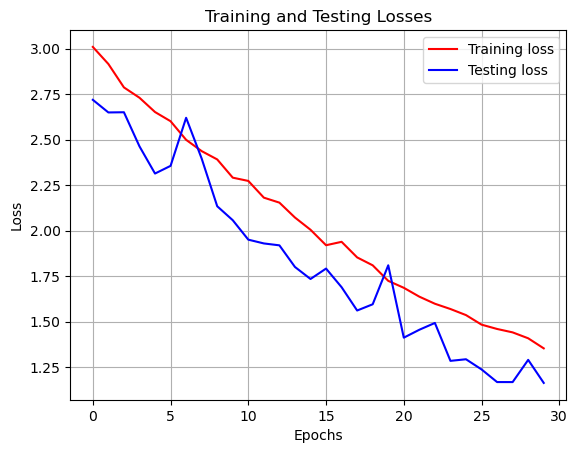

In [26]:
epochs = range(0, num_epochs)
plt.plot(epochs, training_losses, 'r', label='Training loss')
plt.plot(epochs, testing_losses, 'b', label='Testing loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Testing Losses')

plt.grid()
plt.legend()
plt.show()

In [51]:
new_dir = Path("C:/Users/Michał/Documents/SI/saved models")
os.chdir(new_dir)
tc.save(simple_classification_model.state_dict(), "simple_classification_model.pt")

current_dir = os.getcwd()
files = os.listdir(current_dir)
model_filename = 'simple_classification_model.pt'
if model_filename in files:
    print(f'Saved model file {model_filename} found in {current_dir}.')
else:
    print(f'Saved model file {model_filename} not found in {current_dir}.')

Saved model file simple_classification_model.pt found in C:\Users\Michał\Documents\SI\saved models.


In [35]:
classification_model, training_losses, testing_losses = training(classification_network, training_dataloader, validation_dataloader, num_epochs, learning_rate)

Training dataset size: 5604
Testing dataset size: 801
Current epoch: 0
Current epoch training loss: 4.137122928543145
Current epoch validation loss: 3.710491231020619
Current epoch: 1
Current epoch training loss: 3.537327522894555
Current epoch validation loss: 4.257688278860218
Current epoch: 2
Current epoch training loss: 3.102304794888765
Current epoch validation loss: 2.681756838728277
Current epoch: 3
Current epoch training loss: 2.6715102765834136
Current epoch validation loss: 2.5282772495207864
Current epoch: 4
Current epoch training loss: 2.3824333668095483
Current epoch validation loss: 2.2172649665718223
Current epoch: 5
Current epoch training loss: 2.059101507886659
Current epoch validation loss: 1.8146200602718359
Current epoch: 6
Current epoch training loss: 1.8051167419346463
Current epoch validation loss: 1.44057251511144
Current epoch: 7
Current epoch training loss: 1.6245615678034366
Current epoch validation loss: 1.3973320262708915
Current epoch: 8
Current epoch trai

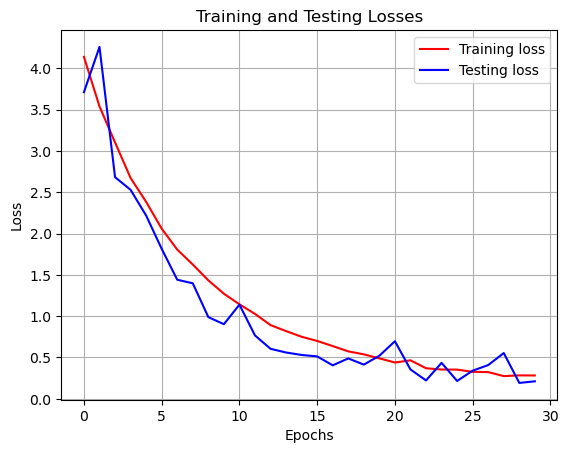

In [36]:
epochs = range(0, num_epochs)
plt.plot(epochs, training_losses, 'r', label='Training loss')
plt.plot(epochs, testing_losses, 'b', label='Testing loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Testing Losses')

plt.grid()
plt.legend()
plt.show()

In [52]:
new_dir = Path("C:/Users/Michał/Documents/SI/saved models")
os.chdir(new_dir)
tc.save(classification_model.state_dict(), "classification_model.pt")

current_dir = os.getcwd()
files = os.listdir(current_dir)
model_filename = 'classification_model.pt'
if model_filename in files:
    print(f'Saved model file {model_filename} found in {current_dir}.')
else:
    print(f'Saved model file {model_filename} not found in {current_dir}.')

Saved model file classification_model.pt found in C:\Users\Michał\Documents\SI\saved models.


In [55]:
improved_classification_model, training_losses, testing_losses = training(improved_classification_network, training_dataloader, validation_dataloader, num_epochs, learning_rate)

Training dataset size: 5604
Testing dataset size: 801
Current epoch: 0
Current epoch training loss: 2.617747164895754
Current epoch validation loss: 2.05509003315972
Current epoch: 1
Current epoch training loss: 2.0889551397904933
Current epoch validation loss: 1.4377115040682675
Current epoch: 2
Current epoch training loss: 1.7270075027471266
Current epoch validation loss: 1.2050202961420446
Current epoch: 3
Current epoch training loss: 1.5503110929866248
Current epoch validation loss: 0.9570550567350733
Current epoch: 4
Current epoch training loss: 1.3373666452902033
Current epoch validation loss: 1.0077332133211
Current epoch: 5
Current epoch training loss: 1.1896852555230717
Current epoch validation loss: 0.5707072952713412
Current epoch: 6
Current epoch training loss: 1.088043201573826
Current epoch validation loss: 0.5440976384576043
Current epoch: 7
Current epoch training loss: 0.9534951937700662
Current epoch validation loss: 0.48720974503980297
Current epoch: 8
Current epoch t

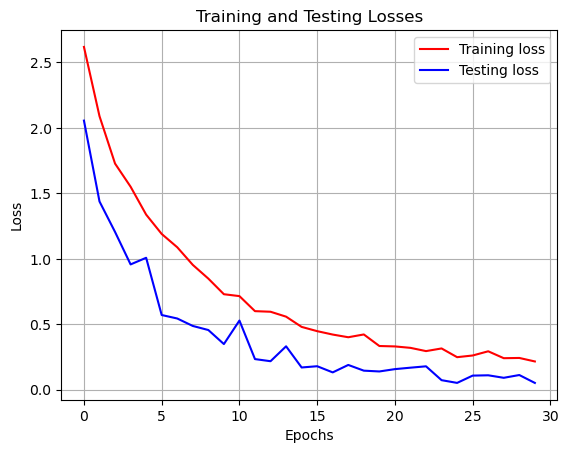

In [56]:
epochs = range(0, num_epochs)
plt.plot(epochs, training_losses, 'r', label='Training loss')
plt.plot(epochs, testing_losses, 'b', label='Testing loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Testing Losses')

plt.grid()
plt.legend()
plt.show()

In [57]:
new_dir = Path("C:/Users/Michał/Documents/SI/saved models")
os.chdir(new_dir)
tc.save(improved_classification_model.state_dict(), "improved_classification_model.pt")

current_dir = os.getcwd()
files = os.listdir(current_dir)
model_filename = 'improved_classification_model.pt'
if model_filename in files:
    print(f'Saved model file {model_filename} found in {current_dir}.')
else:
    print(f'Saved model file {model_filename} not found in {current_dir}.')

Saved model file improved_classification_model.pt found in C:\Users\Michał\Documents\SI\saved models.


In [78]:
resnet18_classification_model, training_losses, testing_losses = training(resnet18_classification, training_dataloader, validation_dataloader, num_epochs, learning_rate)

Training dataset size: 5604
Testing dataset size: 801
Current epoch: 0
Current epoch training loss: 0.23335782541154879
Current epoch validation loss: 0.11008438778420289
Current epoch: 1
Current epoch training loss: 0.07691502758965886
Current epoch validation loss: 0.084926628832067
Current epoch: 2
Current epoch training loss: 0.04659909836955895
Current epoch validation loss: 0.06201332753126541
Current epoch: 3
Current epoch training loss: 0.04939128642371303
Current epoch validation loss: 0.07796907428647397
Current epoch: 4
Current epoch training loss: 0.027912527369135867
Current epoch validation loss: 0.03494820089664278
Current epoch: 5
Current epoch training loss: 0.027152524461592817
Current epoch validation loss: 0.06322916319940272
Current epoch: 6
Current epoch training loss: 0.02071444739668705
Current epoch validation loss: 0.04066826468601023
Current epoch: 7
Current epoch training loss: 0.030508337241114198
Current epoch validation loss: 0.024620862052160852
Current 

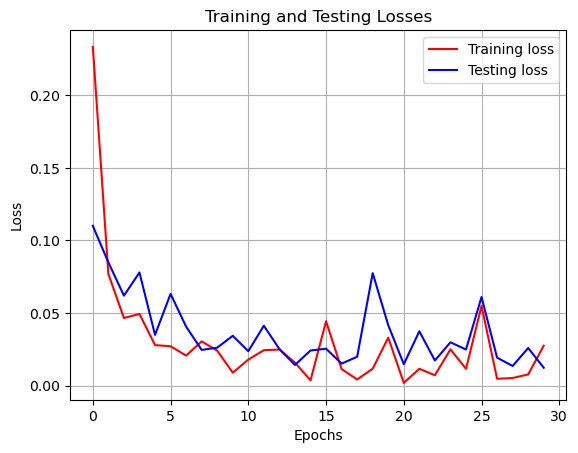

In [79]:
epochs = range(0, num_epochs)
plt.plot(epochs, training_losses, 'r', label='Training loss')
plt.plot(epochs, testing_losses, 'b', label='Testing loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Testing Losses')

plt.grid()
plt.legend()
plt.show()

In [ ]:
new_dir = Path("C:/Users/Michał/Documents/SI/saved models")
os.chdir(new_dir)
tc.save(resnet18_classification_model.state_dict(), "resnet18_classification_model.pt")

current_dir = os.getcwd()
files = os.listdir(current_dir)
model_filename = 'resnet18_classification_model.pt'
if model_filename in files:
    print(f'Saved model file {model_filename} found in {current_dir}.')
else:
    print(f'Saved model file {model_filename} not found in {current_dir}.')

In [17]:
mobilenet_classification_model, training_losses, testing_losses = training(mobilenet_classification, training_dataloader, validation_dataloader, num_epochs, learning_rate)

Training dataset size: 5604
Testing dataset size: 801
Current epoch: 0
Current epoch training loss: 1.1889036756851774
Current epoch validation loss: 0.1487058875861388
Current epoch: 1
Current epoch training loss: 0.1221811440716804
Current epoch validation loss: 0.07079643746849601
Current epoch: 2
Current epoch training loss: 0.06432484071449159
Current epoch validation loss: 0.040552815792154286
Current epoch: 3
Current epoch training loss: 0.051165875615811325
Current epoch validation loss: 0.07604858925921863
Current epoch: 4
Current epoch training loss: 0.04050979033201603
Current epoch validation loss: 0.03168508888555972
Current epoch: 5
Current epoch training loss: 0.030906519124338897
Current epoch validation loss: 0.020752114705397246
Current epoch: 6
Current epoch training loss: 0.024622741921789554
Current epoch validation loss: 0.023771055800242632
Current epoch: 7
Current epoch training loss: 0.032560065623172034
Current epoch validation loss: 0.037948323678243884
Curre

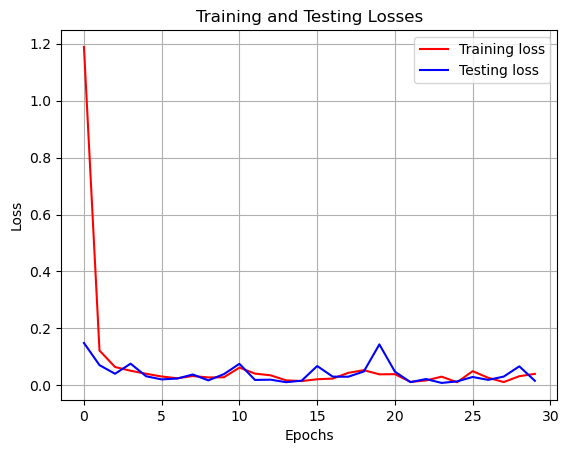

In [18]:
epochs = range(0, num_epochs)
plt.plot(epochs, training_losses, 'r', label='Training loss')
plt.plot(epochs, testing_losses, 'b', label='Testing loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Testing Losses')

plt.grid()
plt.legend()
plt.show()

In [19]:
new_dir = Path("C:/Users/Michał/Documents/SI/saved models")
os.chdir(new_dir)
tc.save(mobilenet_classification_model.state_dict(), "mobilenet_classification_model.pt")

current_dir = os.getcwd()
files = os.listdir(current_dir)
model_filename = 'mobilenet_classification_model.pt'
if model_filename in files:
    print(f'Saved model file {model_filename} found in {current_dir}.')
else:
    print(f'Saved model file {model_filename} not found in {current_dir}.')

Saved model file mobilenet_classification_model.pt found in C:\Users\Michał\Documents\SI\saved models.


# Evaluation

In [15]:
device = "cuda:0" if tc.cuda.is_available() else "cpu"
#print("Device: " + device)
new_dir = Path("C:/Users/Michał/Documents/SI/saved models")
os.chdir(new_dir)

simple_classification_model = SimpleClassificationNetwork().to(device)
simple_classification_model.load_state_dict(tc.load('simple_classification_model.pt'))

classification_model = ClassificationNetwork().to(device)
classification_model.load_state_dict(tc.load('classification_model.pt'))

improved_classification_model = ImprovedClassificationNetwork().to(device)
improved_classification_model.load_state_dict(tc.load('improved_classification_model.pt'))

<All keys matched successfully>

In [16]:
resnet18_classification_model = tc.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True).to(device)
resnet18_classification_model.fc = tc.nn.Linear(512, 100).to(device)
resnet18_classification_model.load_state_dict(tc.load('resnet18_classification_model.pt'))

mobilenet_classification_model = tc.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=True).to(device)
mobilenet_classification_model.classifier[1] = tc.nn.Linear(1280, 100).to(device)
mobilenet_classification_model.load_state_dict(tc.load('mobilenet_classification_model.pt'))

Using cache found in C:\Users\Michał/.cache\torch\hub\pytorch_vision_v0.10.0
Using cache found in C:\Users\Michał/.cache\torch\hub\pytorch_vision_v0.10.0


<All keys matched successfully>

In [17]:
import sklearn.metrics as metrics
import seaborn as sns
from sklearn.metrics import classification_report


def accumulate_predictions(model, dataloader):
  predictions = []
  targets = []
  
  model.eval()
  with tc.set_grad_enabled(False):
      print(f"Dataset size: {len(dataloader.dataset)}")
      for images, classes in dataloader:
        images = images.to(device)
        classes = classes.to(device)

        output = model(images)
        pred = output.argmax(dim=1)

        predictions.append(pred.cpu())
        targets.append(classes.cpu())
  predictions = tc.cat(predictions)
  targets = tc.cat(targets)
  return predictions, targets

Dataset size: 5604
Dataset size: 1602
Training Accuracy: 0.6802284082798001
Testing Accuracy: 0.6504369538077404
Training Report:
              precision    recall  f1-score   support

           0       0.57      0.74      0.64        53
           1       0.68      0.78      0.73        46
          10       0.86      0.57      0.69        42
          11       0.73      0.98      0.84        52
          12       0.64      0.37      0.47        49
          13       0.66      0.26      0.38        72
          14       0.40      0.05      0.08        43
          15       0.35      0.84      0.49        57
          16       0.82      0.94      0.88        49
          17       0.66      0.43      0.52        49
          18       0.53      0.76      0.62        46
          19       0.66      0.79      0.72        66
           2       0.62      0.38      0.47        48
          20       0.63      0.94      0.75        65
          21       0.63      0.66      0.64        59
     

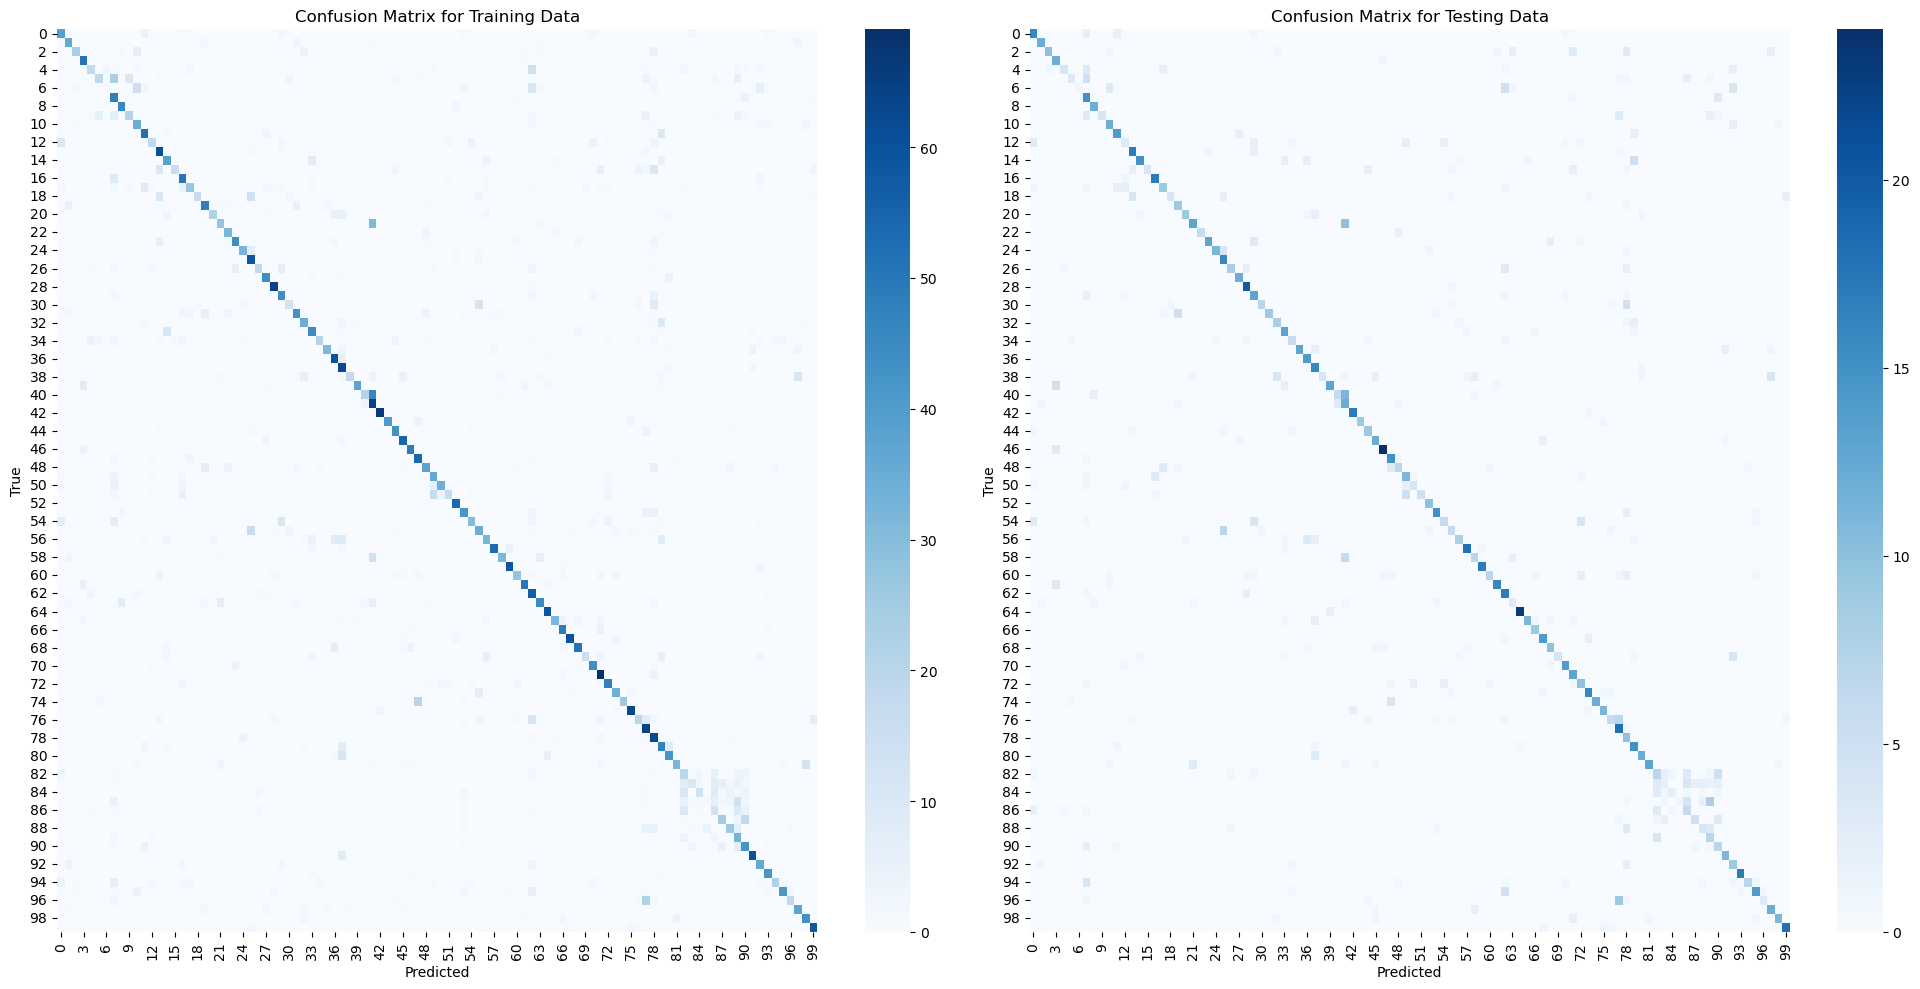

In [32]:
training_predictions, training_targets = accumulate_predictions(simple_classification_model, training_dataloader)
testing_predictions, testing_targets =  accumulate_predictions(simple_classification_model, testing_dataloader)


# Calculate accuracy and sensitivity for training data
training_accuracy = metrics.accuracy_score(training_targets, training_predictions)
training_report = classification_report(training_targets, training_predictions, target_names=classes)

# Calculate accuracy and sensitivity for testing data
testing_accuracy = metrics.accuracy_score(testing_targets, testing_predictions)
testing_report = classification_report(testing_targets, testing_predictions, target_names=classes)

print("Training Accuracy:", training_accuracy)
print("Testing Accuracy:", testing_accuracy)

print("Training Report:")
print(training_report)
print("Testing Report:")
print(testing_report)

training_cm = metrics.confusion_matrix(training_targets, training_predictions)
testing_cm = metrics.confusion_matrix(testing_targets, testing_predictions)

# Create a figure with subplots
fig, axs = plt.subplots(1, 2, figsize=(20, 10))  # Adjust the figsize as per your needs

# Plot the confusion matrix for training data
sns.heatmap(training_cm, cmap='Blues', ax=axs[0])
axs[0].set_xlabel('Predicted')
axs[0].set_ylabel('True')
axs[0].set_title('Confusion Matrix for Training Data')

# Plot the confusion matrix for testing data
sns.heatmap(testing_cm, cmap='Blues', ax=axs[1])
axs[1].set_xlabel('Predicted')
axs[1].set_ylabel('True')
axs[1].set_title('Confusion Matrix for Testing Data')

plt.tight_layout()  # Adjust the spacing between subplots

plt.show()

Dataset size: 5604
Dataset size: 1602
Training Accuracy: 0.9493219129193433
Testing Accuracy: 0.9263420724094882
Training Report:
              precision    recall  f1-score   support

           0       0.96      0.94      0.95        53
           1       1.00      0.98      0.99        46
          10       0.82      1.00      0.90        42
          11       1.00      1.00      1.00        52
          12       1.00      0.92      0.96        49
          13       1.00      1.00      1.00        72
          14       0.91      1.00      0.96        43
          15       0.90      1.00      0.95        57
          16       0.98      1.00      0.99        49
          17       0.96      0.96      0.96        49
          18       1.00      0.89      0.94        46
          19       1.00      0.98      0.99        66
           2       1.00      0.83      0.91        48
          20       1.00      0.92      0.96        65
          21       1.00      1.00      1.00        59
     

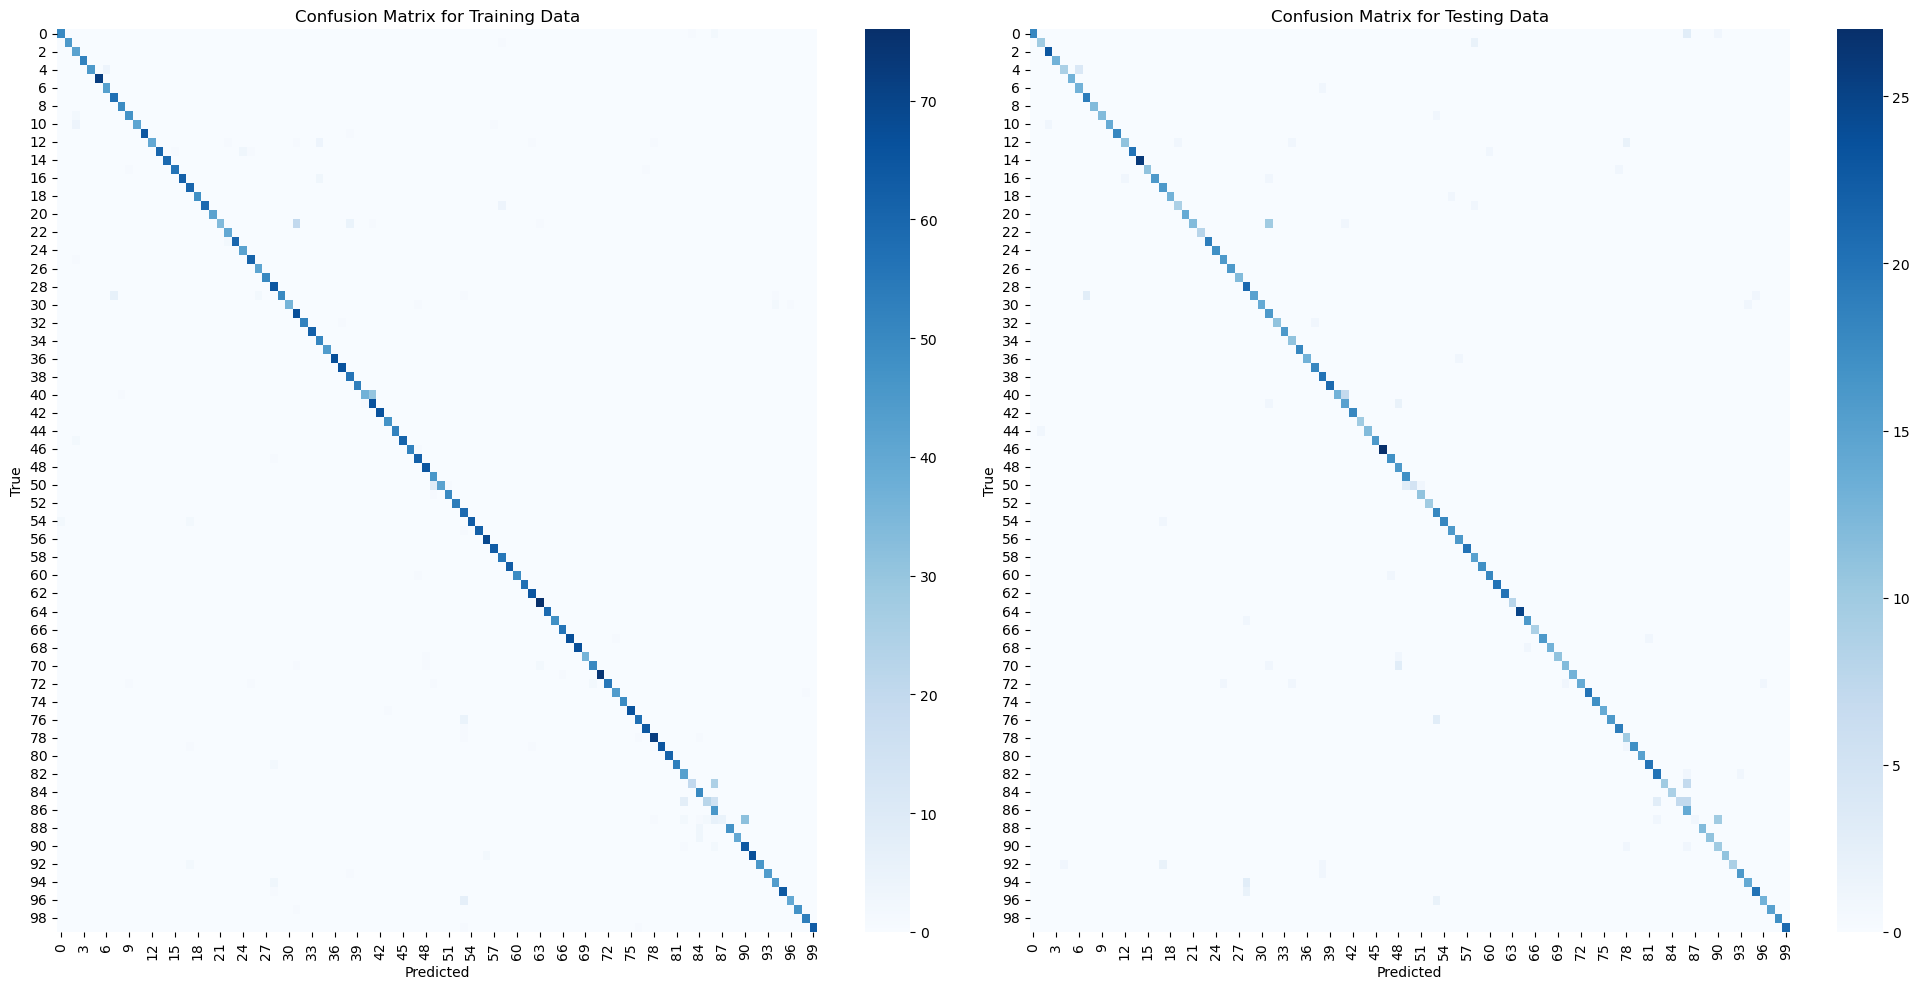

In [20]:
training_predictions, training_targets = accumulate_predictions(classification_model, training_dataloader)
testing_predictions, testing_targets =  accumulate_predictions(classification_model, testing_dataloader)

training_cm = metrics.confusion_matrix(training_targets, training_predictions)
testing_cm = metrics.confusion_matrix(testing_targets, testing_predictions)

# Calculate accuracy and sensitivity for training data
training_accuracy = metrics.accuracy_score(training_targets, training_predictions)
training_report = classification_report(training_targets, training_predictions, target_names=classes)

# Calculate accuracy and sensitivity for testing data
testing_accuracy = metrics.accuracy_score(testing_targets, testing_predictions)
testing_report = classification_report(testing_targets, testing_predictions, target_names=classes)

print("Training Accuracy:", training_accuracy)
print("Testing Accuracy:", testing_accuracy)

print("Training Report:")
print(training_report)
print("Testing Report:")
print(testing_report)

# Create a figure with subplots
fig, axs = plt.subplots(1, 2, figsize=(20, 10))  # Adjust the figsize as per your needs

# Plot the confusion matrix for training data
sns.heatmap(training_cm, cmap='Blues', ax=axs[0])
axs[0].set_xlabel('Predicted')
axs[0].set_ylabel('True')
axs[0].set_title('Confusion Matrix for Training Data')

# Plot the confusion matrix for testing data
sns.heatmap(testing_cm, cmap='Blues', ax=axs[1])
axs[1].set_xlabel('Predicted')
axs[1].set_ylabel('True')
axs[1].set_title('Confusion Matrix for Testing Data')

plt.tight_layout()  # Adjust the spacing between subplots

plt.show()

Dataset size: 5604
Dataset size: 1602
Training Accuracy: 0.994825124910778
Testing Accuracy: 0.9850187265917603
Training Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        53
           1       1.00      1.00      1.00        46
          10       1.00      1.00      1.00        42
          11       1.00      1.00      1.00        52
          12       1.00      1.00      1.00        49
          13       1.00      1.00      1.00        72
          14       1.00      1.00      1.00        43
          15       1.00      1.00      1.00        57
          16       0.98      1.00      0.99        49
          17       1.00      1.00      1.00        49
          18       1.00      1.00      1.00        46
          19       1.00      1.00      1.00        66
           2       1.00      0.98      0.99        48
          20       1.00      1.00      1.00        65
          21       0.91      1.00      0.95        59
      

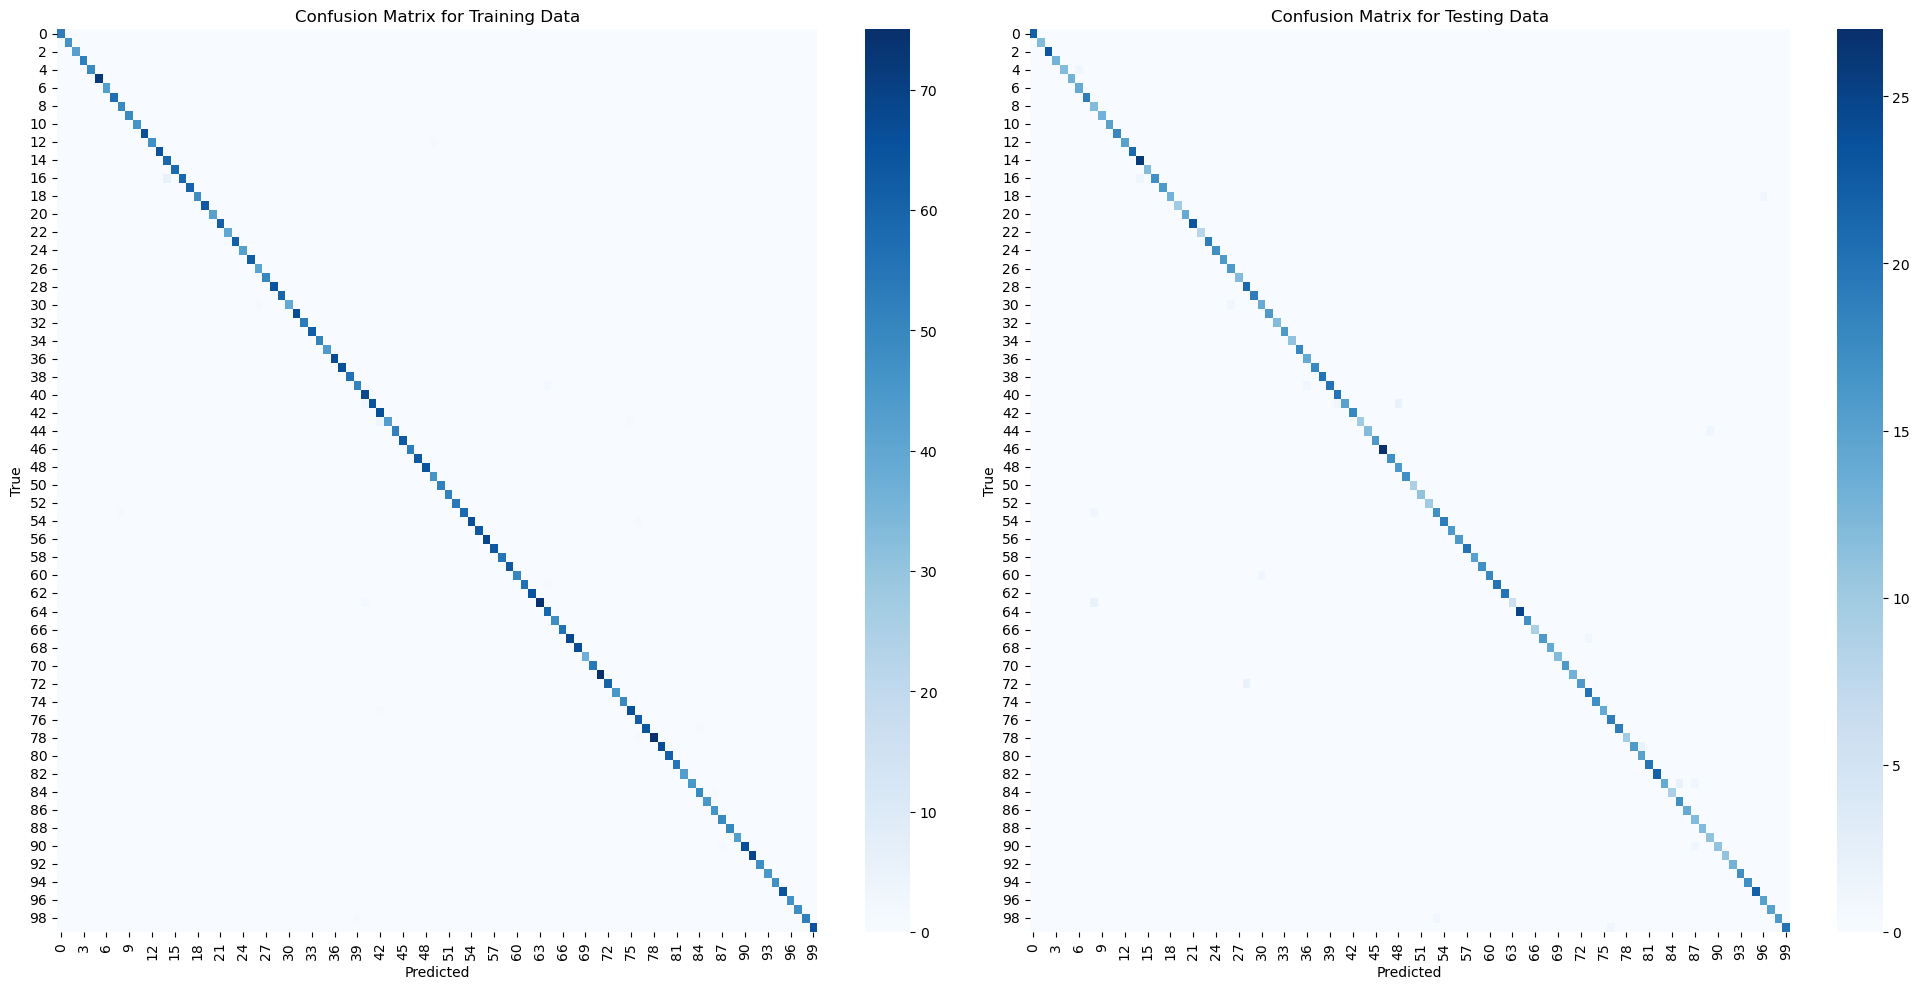

In [21]:
training_predictions, training_targets = accumulate_predictions(improved_classification_model, training_dataloader)
testing_predictions, testing_targets =  accumulate_predictions(improved_classification_model, testing_dataloader)

training_cm = metrics.confusion_matrix(training_targets, training_predictions)
testing_cm = metrics.confusion_matrix(testing_targets, testing_predictions)

# Calculate accuracy and sensitivity for training data
training_accuracy = metrics.accuracy_score(training_targets, training_predictions)
training_report = classification_report(training_targets, training_predictions, target_names=classes)

# Calculate accuracy and sensitivity for testing data
testing_accuracy = metrics.accuracy_score(testing_targets, testing_predictions)
testing_report = classification_report(testing_targets, testing_predictions, target_names=classes)

print("Training Accuracy:", training_accuracy)
print("Testing Accuracy:", testing_accuracy)

print("Training Report:")
print(training_report)
print("Testing Report:")
print(testing_report)

# Create a figure with subplots
fig, axs = plt.subplots(1, 2, figsize=(20, 10))  # Adjust the figsize as per your needs

# Plot the confusion matrix for training data
sns.heatmap(training_cm, cmap='Blues', ax=axs[0])
axs[0].set_xlabel('Predicted')
axs[0].set_ylabel('True')
axs[0].set_title('Confusion Matrix for Training Data')

# Plot the confusion matrix for testing data
sns.heatmap(testing_cm, cmap='Blues', ax=axs[1])
axs[1].set_xlabel('Predicted')
axs[1].set_ylabel('True')
axs[1].set_title('Confusion Matrix for Testing Data')

plt.tight_layout()  # Adjust the spacing between subplots

plt.show()

Dataset size: 5604
Dataset size: 1602
Training Accuracy: 0.9998215560314061
Testing Accuracy: 0.9968789013732834
Training Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        53
           1       1.00      1.00      1.00        46
          10       1.00      1.00      1.00        42
          11       1.00      1.00      1.00        52
          12       1.00      1.00      1.00        49
          13       1.00      1.00      1.00        72
          14       1.00      1.00      1.00        43
          15       1.00      1.00      1.00        57
          16       1.00      1.00      1.00        49
          17       1.00      1.00      1.00        49
          18       1.00      1.00      1.00        46
          19       1.00      1.00      1.00        66
           2       1.00      1.00      1.00        48
          20       1.00      1.00      1.00        65
          21       1.00      1.00      1.00        59
     

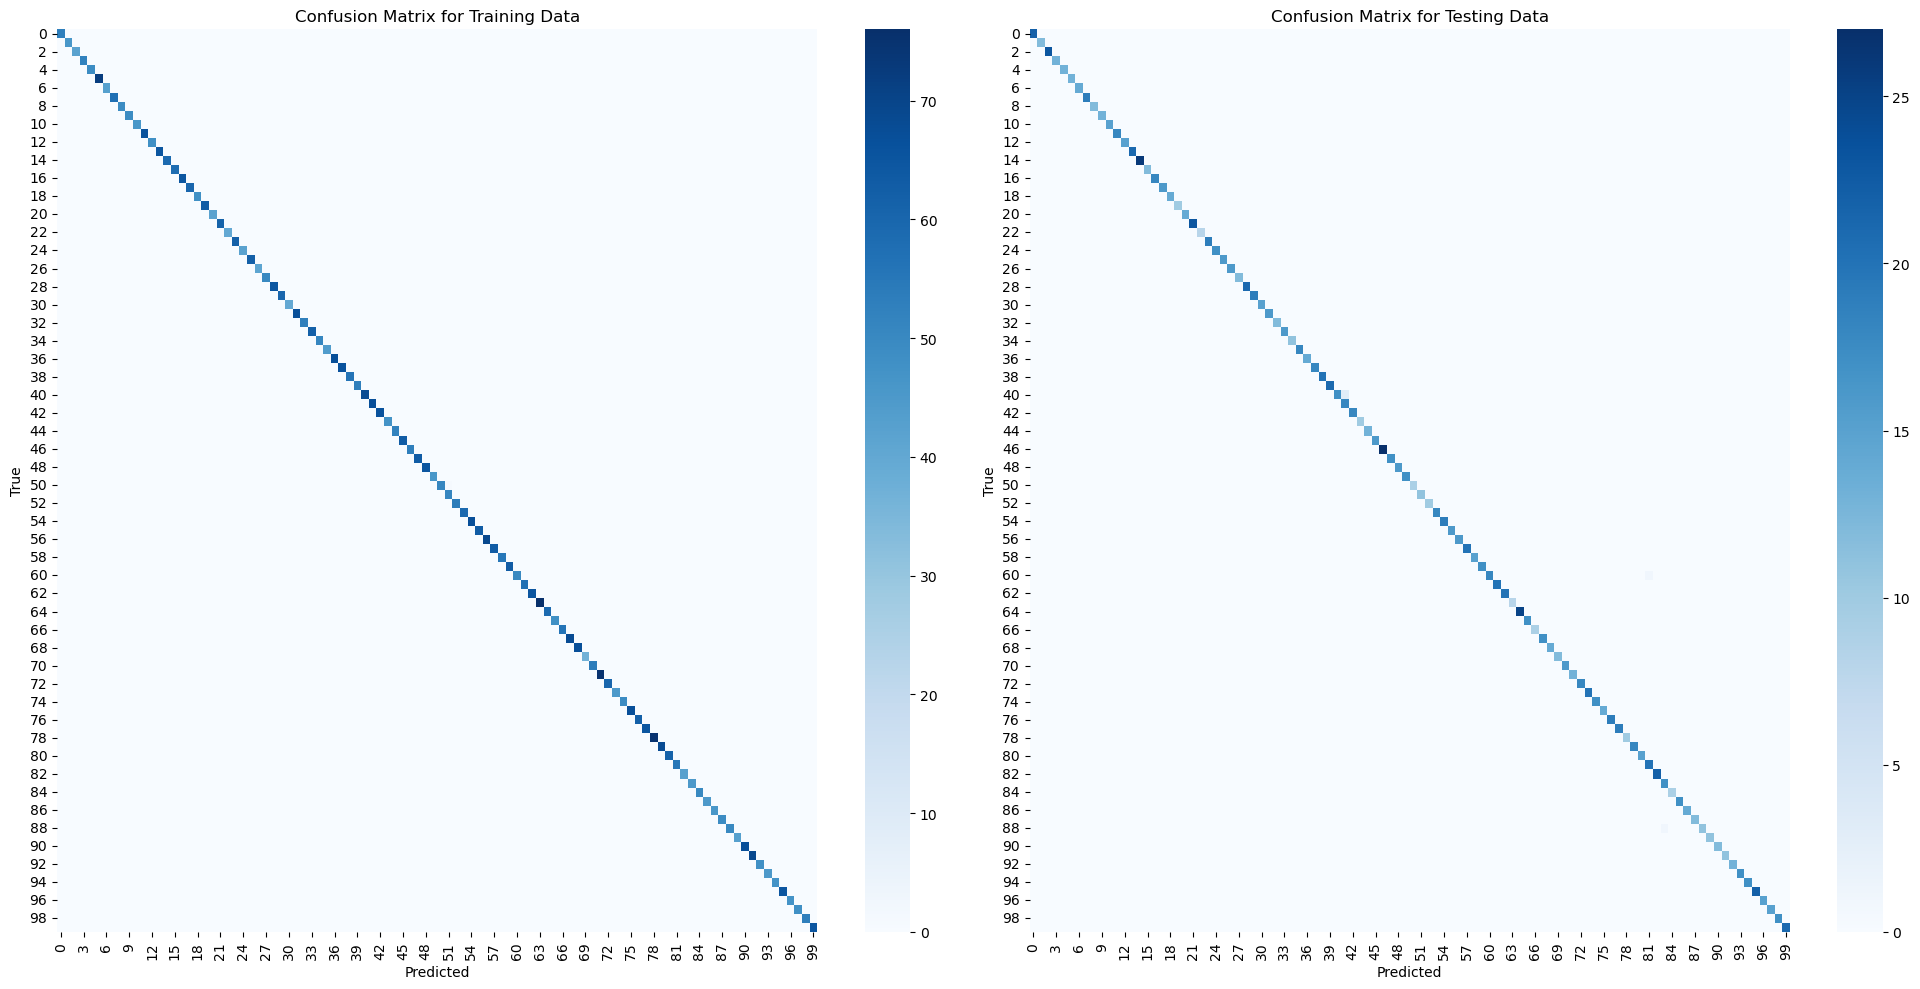

In [22]:
training_predictions, training_targets = accumulate_predictions(resnet18_classification_model, training_dataloader)
testing_predictions, testing_targets =  accumulate_predictions(resnet18_classification_model, testing_dataloader)

training_cm = metrics.confusion_matrix(training_targets, training_predictions)
testing_cm = metrics.confusion_matrix(testing_targets, testing_predictions)

# Calculate accuracy and sensitivity for training data
training_accuracy = metrics.accuracy_score(training_targets, training_predictions)
training_report = classification_report(training_targets, training_predictions, target_names=classes)

# Calculate accuracy and sensitivity for testing data
testing_accuracy = metrics.accuracy_score(testing_targets, testing_predictions)
testing_report = classification_report(testing_targets, testing_predictions, target_names=classes)

print("Training Accuracy:", training_accuracy)
print("Testing Accuracy:", testing_accuracy)

print("Training Report:")
print(training_report)
print("Testing Report:")
print(testing_report)

# Create a figure with subplots
fig, axs = plt.subplots(1, 2, figsize=(20, 10))  # Adjust the figsize as per your needs

# Plot the confusion matrix for training data
sns.heatmap(training_cm, cmap='Blues', ax=axs[0])
axs[0].set_xlabel('Predicted')
axs[0].set_ylabel('True')
axs[0].set_title('Confusion Matrix for Training Data')

# Plot the confusion matrix for testing data
sns.heatmap(testing_cm, cmap='Blues', ax=axs[1])
axs[1].set_xlabel('Predicted')
axs[1].set_ylabel('True')
axs[1].set_title('Confusion Matrix for Testing Data')

plt.tight_layout()  # Adjust the spacing between subplots

plt.show()

Dataset size: 5604
Dataset size: 1602
Training Accuracy: 0.9998215560314061
Testing Accuracy: 0.9950062421972534
Training Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        53
           1       1.00      1.00      1.00        46
          10       1.00      1.00      1.00        42
          11       1.00      1.00      1.00        52
          12       1.00      1.00      1.00        49
          13       1.00      1.00      1.00        72
          14       1.00      1.00      1.00        43
          15       1.00      1.00      1.00        57
          16       1.00      1.00      1.00        49
          17       1.00      1.00      1.00        49
          18       1.00      1.00      1.00        46
          19       1.00      1.00      1.00        66
           2       1.00      1.00      1.00        48
          20       1.00      1.00      1.00        65
          21       1.00      1.00      1.00        59
     

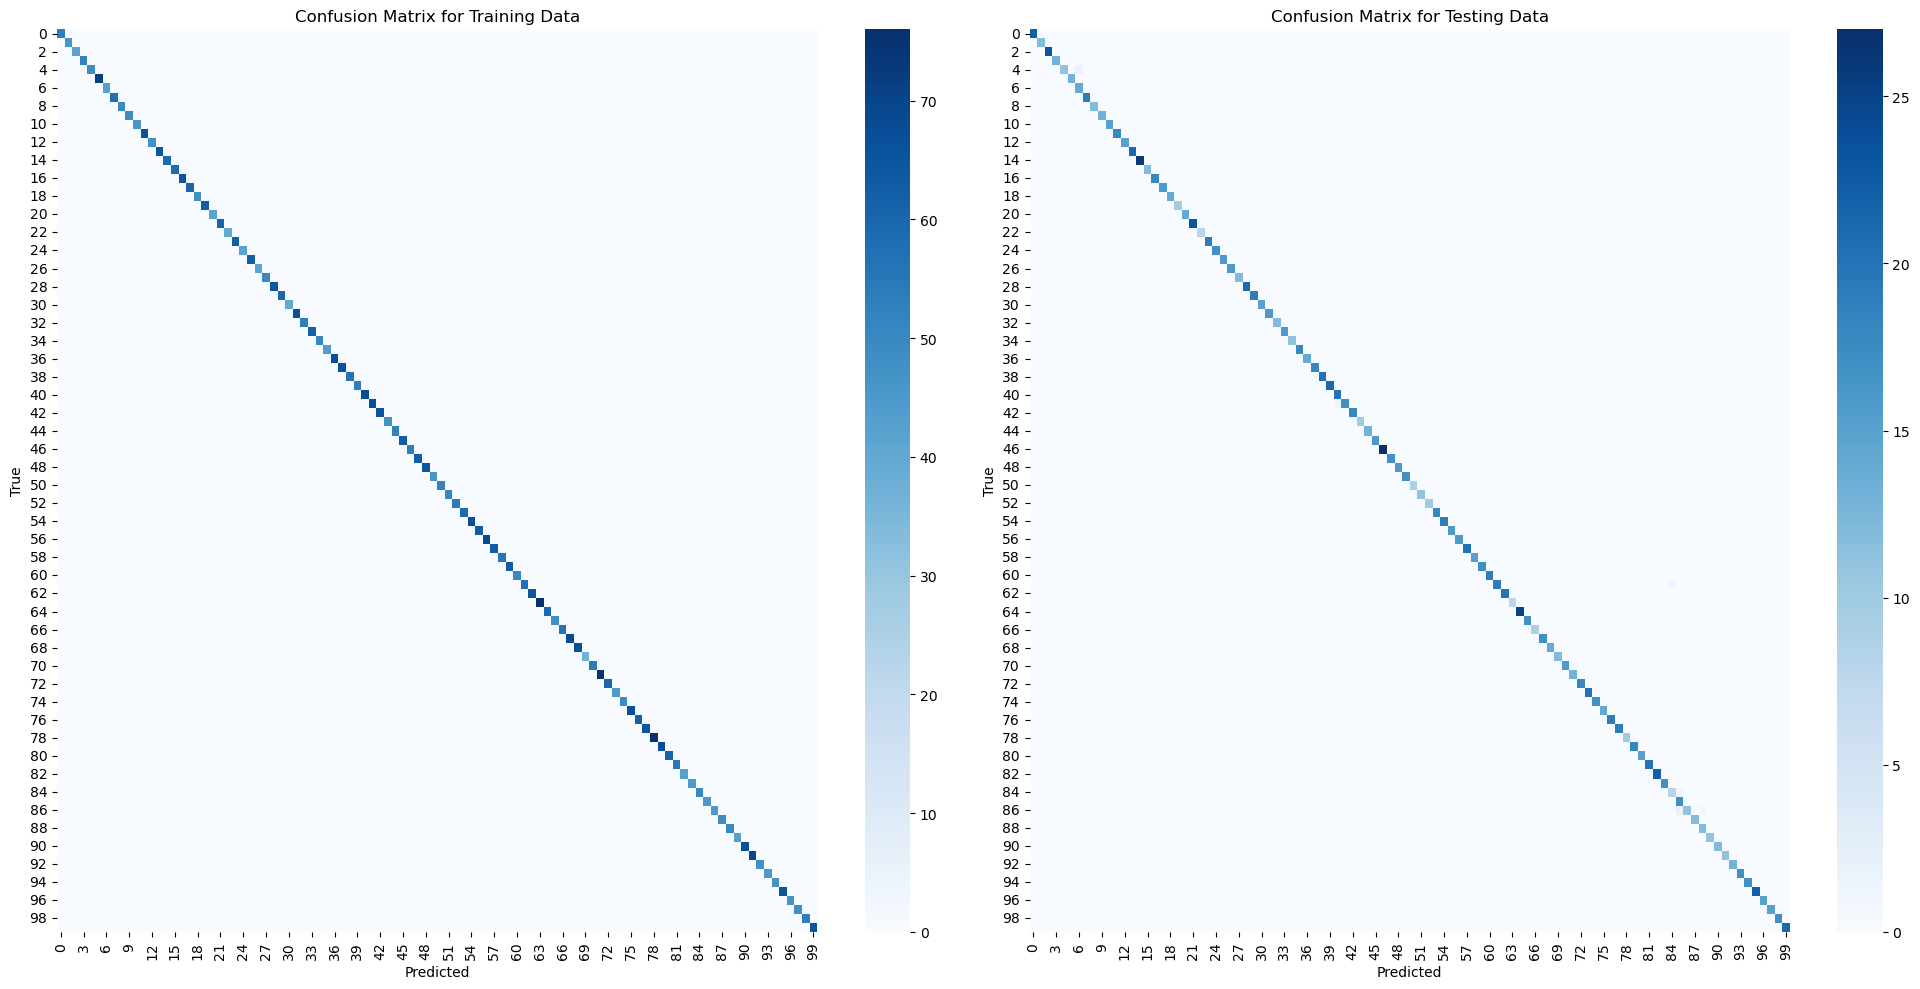

In [23]:
training_predictions, training_targets = accumulate_predictions(mobilenet_classification_model, training_dataloader)
testing_predictions, testing_targets =  accumulate_predictions(mobilenet_classification_model, testing_dataloader)

training_cm = metrics.confusion_matrix(training_targets, training_predictions)
testing_cm = metrics.confusion_matrix(testing_targets, testing_predictions)

# Calculate accuracy and sensitivity for training data
training_accuracy = metrics.accuracy_score(training_targets, training_predictions)
training_report = classification_report(training_targets, training_predictions, target_names=classes)

# Calculate accuracy and sensitivity for testing data
testing_accuracy = metrics.accuracy_score(testing_targets, testing_predictions)
testing_report = classification_report(testing_targets, testing_predictions, target_names=classes)

print("Training Accuracy:", training_accuracy)
print("Testing Accuracy:", testing_accuracy)

print("Training Report:")
print(training_report)
print("Testing Report:")
print(testing_report)

# Create a figure with subplots
fig, axs = plt.subplots(1, 2, figsize=(20, 10))  # Adjust the figsize as per your needs

# Plot the confusion matrix for training data
sns.heatmap(training_cm, cmap='Blues', ax=axs[0])
axs[0].set_xlabel('Predicted')
axs[0].set_ylabel('True')
axs[0].set_title('Confusion Matrix for Training Data')

# Plot the confusion matrix for testing data
sns.heatmap(testing_cm, cmap='Blues', ax=axs[1])
axs[1].set_xlabel('Predicted')
axs[1].set_ylabel('True')
axs[1].set_title('Confusion Matrix for Testing Data')

plt.tight_layout()  # Adjust the spacing between subplots

plt.show()

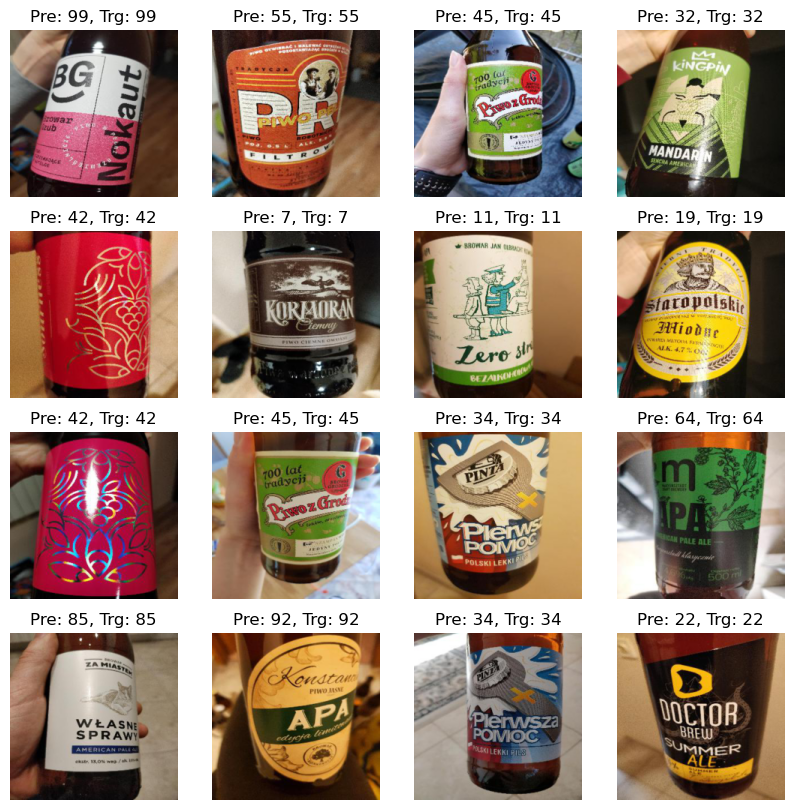

In [24]:
predictions = []
targets = []
  
with tc.set_grad_enabled(False):
  for images, classes in testing_dataloader:
    images2 = images.to(device)
    classes = classes.to(device)

    output = improved_classification_model(images2)
    pred = output.argmax(dim=1)

    predictions.append(pred.cpu())
    targets.append(classes.cpu())

    fig, axs = plt.subplots(4, 4, figsize=(10, 10))
    axs = axs.ravel()
    for i in range(16):
      image = np.transpose(images[i].numpy(), (1, 2, 0))
      image = (image + 1) / 2
      axs[i].imshow(image)
      axs[i].set_title(f"Pre: {predictions[0][i]}, Trg: {targets[0][i]}")
      axs[i].axis('off')
    plt.show()
    break